



Confusion matrix:
 [[ 0  3]
 [ 0 11]] Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.79      1.00      0.88        11

    accuracy                           0.79        14
   macro avg       0.39      0.50      0.44        14
weighted avg       0.62      0.79      0.69        14
 Accuracy: 0.7857142857142857
Feature Importance Table


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Importance,Features
0,1.0,UNNAMED: 0_x


Histogram of Feature Importance


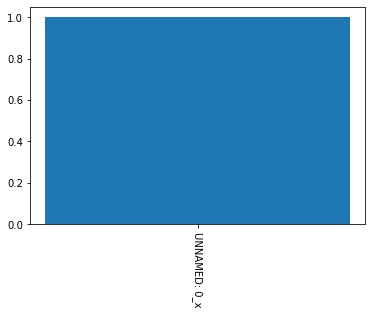

Feature Beeswarm Plot


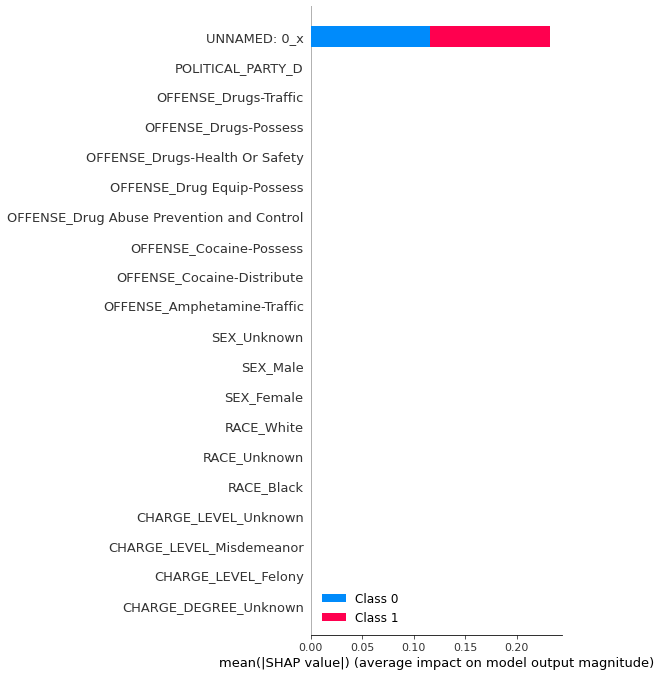

The least populated class in y has only 3 members, which is less than n_splits=5.


Confusion matrix:
 [[ 0  2]
 [ 0 19]] Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      1.00      0.95        19

    accuracy                           0.90        21
   macro avg       0.45      0.50      0.48        21
weighted avg       0.82      0.90      0.86        21
 Accuracy: 0.9047619047619048
Feature Importance Table


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Importance,Features
13,1.0,SEX_Unknown


Histogram of Feature Importance


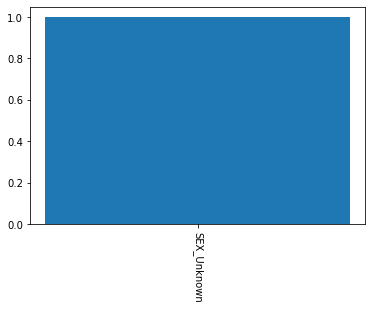

Feature Beeswarm Plot


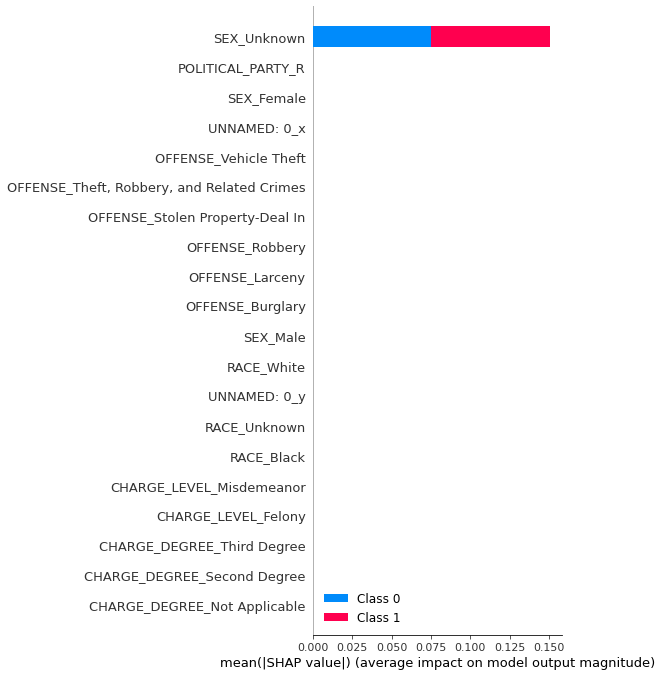

train RMSE: 5.660950701609912 
test RMSE: 7.80551204072555
Feature Importance Table


,Importance,Features


Histogram of Feature Importance


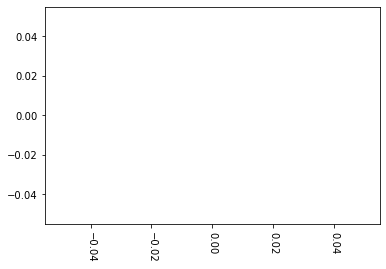

Feature Beeswarm Plot


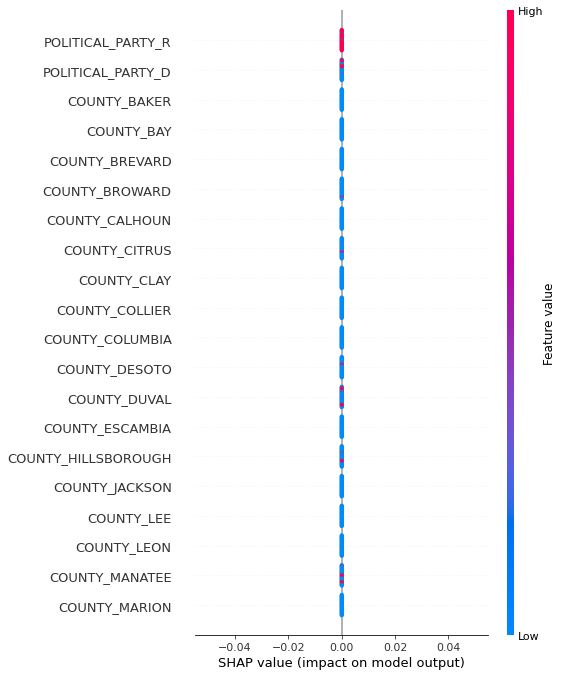

train RMSE: 5.544345698224793 
test RMSE: 3.8251345907120613
Feature Importance Table


,Importance,Features


Histogram of Feature Importance


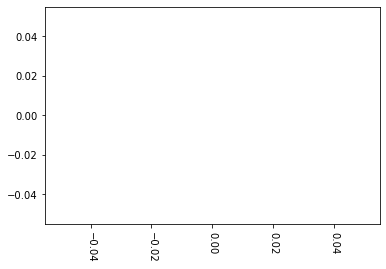

Feature Beeswarm Plot


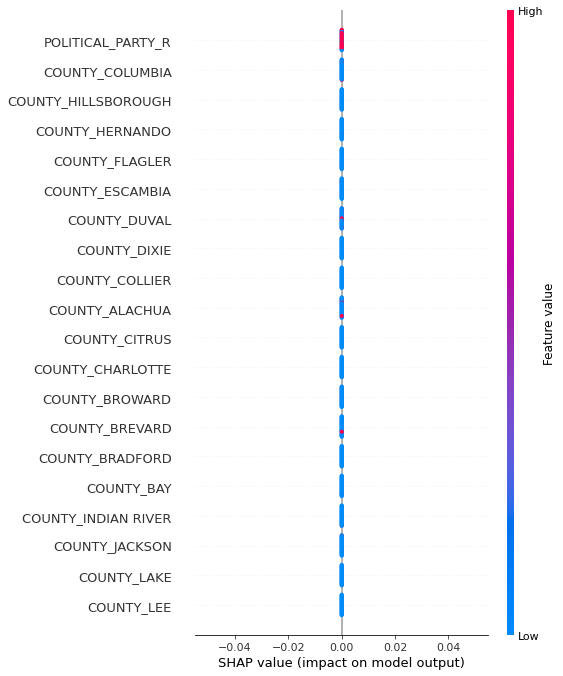

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\tnanc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\tnanc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "c:\Users\tnanc\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\tnanc\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\tnanc\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Users\tnanc\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_asy

Confusion matrix:
 [[ 0  3]
 [ 0 11]] Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.79      1.00      0.88        11

    accuracy                           0.79        14
   macro avg       0.39      0.50      0.44        14
weighted avg       0.62      0.79      0.69        14
 Accuracy: 0.7857142857142857
Feature Importance Table


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Importance,Features


Histogram of Feature Importance


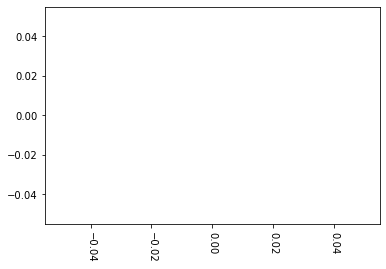

Feature Beeswarm Plot


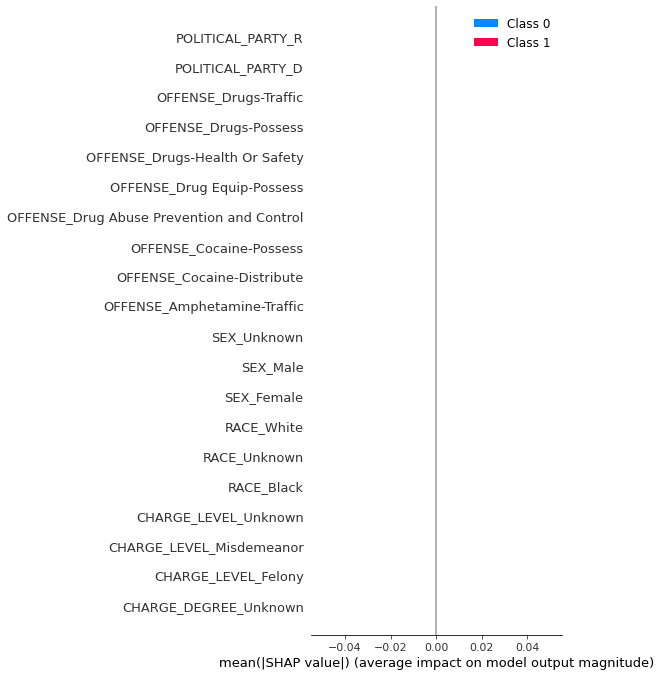

The least populated class in y has only 3 members, which is less than n_splits=5.
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\tnanc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\tnanc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "c:\Users\tnanc\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\tnanc\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\tnanc\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Users\tnanc

Confusion matrix:
 [[ 0  2]
 [ 0 19]] Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      1.00      0.95        19

    accuracy                           0.90        21
   macro avg       0.45      0.50      0.48        21
weighted avg       0.82      0.90      0.86        21
 Accuracy: 0.9047619047619048
Feature Importance Table


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\tnanc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\tnanc\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "c:\Users\tnanc\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\tnanc\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\tnanc\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Users\tnanc\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_asy

,Importance,Features


Histogram of Feature Importance


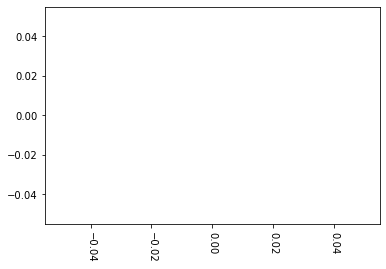

Feature Beeswarm Plot


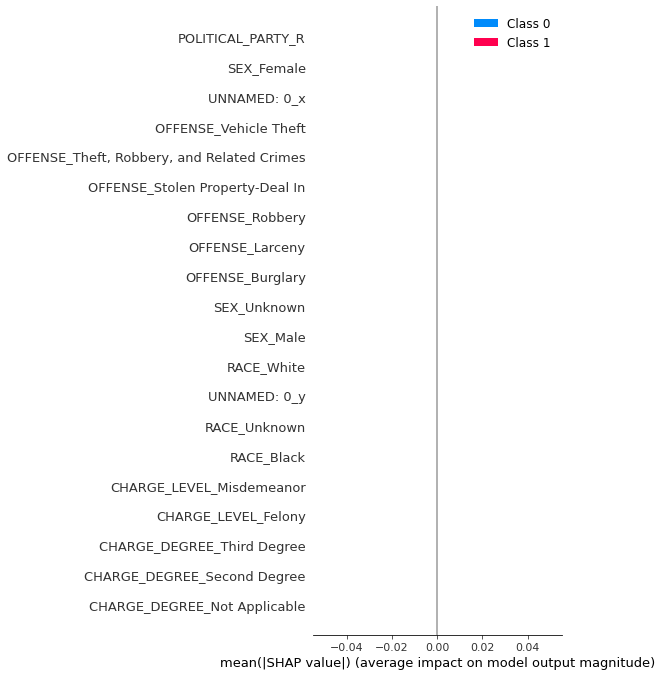

train RMSE: 5.660951633725461 
test RMSE: 7.8062716688070175
Feature Importance Table


,Importance,Features


Histogram of Feature Importance


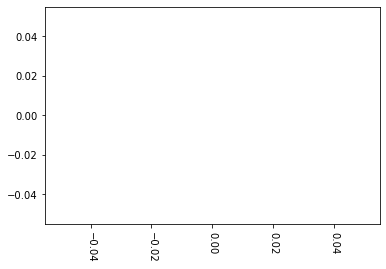

Feature Beeswarm Plot


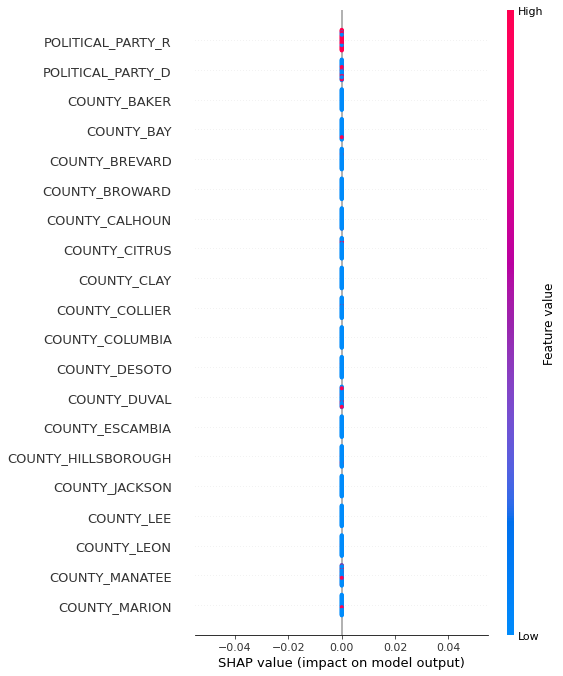

train RMSE: 5.547349916218366 
test RMSE: 3.7684423914432394
Feature Importance Table


,Importance,Features


Histogram of Feature Importance


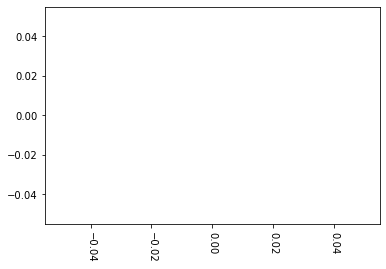

Feature Beeswarm Plot


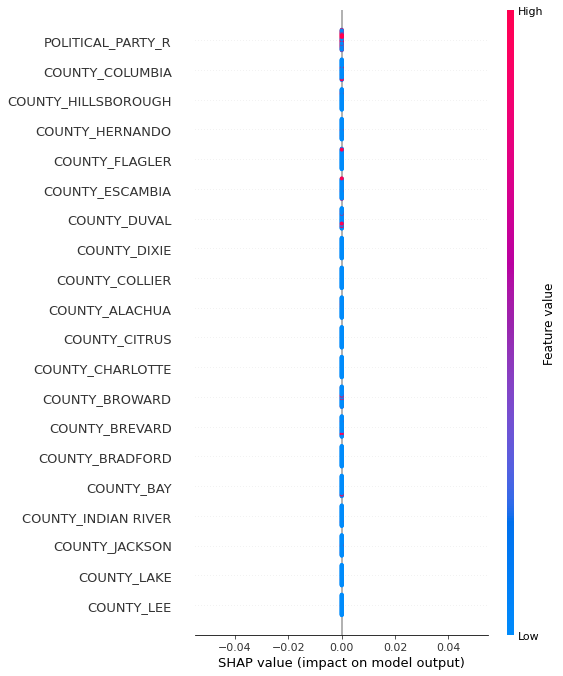

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\tnanc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\tnanc\anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "c:\Users\tnanc\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1231, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\Users\tnanc\anaconda3\lib\site-packages\xgboost\sklearn.py", line 286, in _wrap_evaluation_matrices
  

ValueError: feature_names must be unique

In [1]:
#import required functions
# Note: If you have not previously used some of these packages (such as shap), you may need to install them
# We apologize for any inconvenience due to installing packages
# However, it is impossible for us to know in advance the packages each individual has installed

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score, mean_squared_error
from xgboost import XGBRegressor, XGBClassifier

import shap
from functools import reduce

#Read-in custom functions
import CleanSAO
from CleanFDOC import clean_fdoc
from CreateCCMaster import create_ccm
from CreateModelDF import model_df
from TreeModels import get_tree

#set working path

dir = os.getcwd()
path = dir #+'/data/'
os.chdir(path)

#Clean charges(prosecutor specific actions) datasets (drug, theft)
drug_sa_clean, theft_sa_clean = CleanSAO.clean_sao('CjdtSAOCase_00000_sample.csv')

#Clean sentencing (offenses) datasets (drug, theft)
drug_offenses_clean, theft_offenses_clean = clean_fdoc(['Active_Offenses_PRPR_sample.csv', 'Active_Offenses_CPS_sample.csv', 
                                                       'Release_Offenses_PRPR_sample.csv', 'Release_Offenses_CPS_sample.csv', 
                                                       'Active_Root_sample.csv', 'Release_Root_sample.csv'])

#Circuit-county-year political/State Attorney dataset
ccm = create_ccm(safile = "SA_Political_Leanings_sample.csv", 
                    housefile = "clean_house_sample.csv", 
                    senatefile = "clean_senate_sample.csv", 
                    presfile = "clean_pres_sample.csv", 
                    circuitcountyfile="circuit_county_crosswalk_sample.csv")
                    
# Compile modeling datasets
drug_sa_df = model_df(drug_sa_clean, ccm, obstype = 'action', crimetype = 'drug')
theft_sa_df = model_df(theft_sa_clean, ccm, obstype = 'action', crimetype = 'theft')
drug_off_df = model_df(drug_offenses_clean, ccm, obstype = 'offense', crimetype = 'drug')
theft_off_df = model_df(theft_offenses_clean, ccm, obstype = 'offense', crimetype = 'theft')

#CART Model Hyperparameters
cart = {'max_depth':[3, 6, 10], 
        'min_samples_split':[8, 20], 
        'min_samples_leaf': [10, 20, 100]}

#CART Model Drug Charges
drug_sa_tree = get_tree(drug_sa_df, target = 'FINAL_ACTION_DESC', paramdict = cart, model = DecisionTreeClassifier,  seed = 42)

#CART Model Theft Charges
theft_sa_tree = get_tree(theft_sa_df, target = 'FINAL_ACTION_DESC', paramdict = cart, model = DecisionTreeClassifier, seed = 42)

#CART Model Drug Sentencing
drug_off_tree = get_tree(drug_off_df, target = 'TERM_YEARS', paramdict = cart, model = DecisionTreeRegressor, seed = 42)

#CART Model Theft Sentencing
theft_off_tree = get_tree(theft_off_df, 'TERM_YEARS', paramdict = cart, model = DecisionTreeRegressor, seed = 42)

#Random Forest hyperarameter space
bag = {'max_depth':[10, 15], 
        'min_samples_leaf': [100, 200], 
        'max_features': [40, 80], 
        'n_estimators':[15, 20]} 

#Random Forest Drug Charges        
drug_sa_tree = get_tree(drug_sa_df, target = 'FINAL_ACTION_DESC', paramdict = bag, model = RandomForestClassifier, seed = 42)

#Random Forest Theft Charges
theft_sa_tree = get_tree(theft_sa_df, target = 'FINAL_ACTION_DESC', paramdict = bag, model = RandomForestClassifier, seed = 42)

#Random Forest Drug Sentencing
drug_off_tree = get_tree(drug_off_df, target = 'TERM_YEARS', paramdict = bag, model = RandomForestRegressor, seed = 42)

#Random Forest Theft Sentencing
theft_off_tree = get_tree(theft_off_df, target = 'TERM_YEARS', paramdict = bag, model = RandomForestRegressor, seed = 42)

#XGBoost Hyperparameters for Classifier models
xgbag = {'max_depth':[4, 6], 
        'min_child_weight':[10, 20],
        'alpha': [0.1, 0.2],
        'colsample_bytree': [0.6, 0.75]} 

#XGBoost Drug Charges
drug_sa_tree = get_tree(drug_sa_df, target = 'FINAL_ACTION_DESC', paramdict = xgbag, model = XGBClassifier, seed =10)

#XGBoost Theft Charges
theft_sa_tree = get_tree(theft_sa_df, target = 'FINAL_ACTION_DESC', paramdict = xgbag, model = XGBClassifier,seed=10)

#XGBoost Hyperparameters for Regression models
boost = {'max_depth':[8, 12], 
        'min_child_weight':[10, 20],
        'alpha': [0.1, 0.2],
        'colsample_bytree': [0.6, 0.75]}
        
#XGBoost Drug Sentencing
drug_off_tree = get_tree(drug_off_df, target = 'TERM_YEARS', paramdict = boost, model = XGBRegressor, seed=42)

#XGBoost Theft Sentencing
theft_off_tree = get_tree(theft_off_df, 'TERM_YEARS', paramdict = boost, model =XGBRegressor, seed = 42)